# Basic usage

This notebook will provide users with a broad overview of `opticam_new`'s features by reducing some synthetic data. For more detail about each aspect of `opticam_new`, see the dedicated tutorials.

First things first, let's generate some data:

In [1]:
from opticam_new.generate import create_synthetic_observations, create_synthetic_flats

create_synthetic_observations(out_dir='data', overwrite=True)  # generate some synthetic observations
create_synthetic_flats(out_dir='flats', overwrite=True)  # generate some synthetic flat-field images

Creating synthetic observations: 100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


These synthetic data come in three filters: "g", "i", and "r".

The first step in reducing any OPTICAM data is to initialise a `Catalog()` object. We will store any output files in the `reduced` directory, which will be created if it does not already exist. We will also apply flat-field corrections by passing a `FlatFieldCorrector` (see the [corrections tutorial](applying_corrections.ipynb) for more details):

In [2]:
from opticam_new import Catalog, FlatFieldCorrector

cat = Catalog(
    data_directory='data/',  # path to the simulated data
    out_directory='reduced/',  # path to where output will be saved
    flat_corrector=FlatFieldCorrector(out_dir='master_flats', flats_dir='flats'),  # flat field corrector
    remove_cosmic_rays=False,  # disable cosmic ray removal for better performance (since these are simulated data)
    show_plots=True,
    )

[OPTICAM] Scanning data directory:   0%|          | 0/300 [00:00<?, ?it/s]

[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 100 g-band images.
[OPTICAM] 100 r-band images.
[OPTICAM] 100 i-band images.
[OPTICAM] Read g-band catalog from file.
[OPTICAM] Read r-band catalog from file.
[OPTICAM] Read i-band catalog from file.


After initialising a `Catalog` object, you will see the image binnings, the filters used, and the number of images for each filter. If more than one binning value is detected, an error will be raised and the binning value for each file will be logged in `out_directory/diag/binnings.json`. Similarly, an error will be raised if more than three filters are detected, with the filter for each file being logged in `out_directory/diag/filters.json`. In this case, there were no problems with our data, and so we can proceed with reduction.

The next step is to create source catalogs for each camera. Initialising catalogs requires aligning each camera's images, and so this method is where the alignment parameters can be tweaked. Ideally, only small x, y translations should be needed. By default, images will be aligned `transform_type='translation'`, using the three brightest sources in the field as references. However, `euclidean` (translation and rotation) and `similarity` (translation, rotation, and scaling) are also available. The number of reference sources can also be changed, though 2 is the minimum for `euclidean` and `similarity`, and 1 is the minimum for `translation`. Try with 3 first, then tweak if needed.

To initialise the source catalogs, it is necessary to 'call' the `Catalog` object:

[OPTICAM] Initialising catalogs ...


[OPTICAM] Aligning g-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Done.
[OPTICAM] 100 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Done.
[OPTICAM] 100 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Done.
[OPTICAM] 100 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


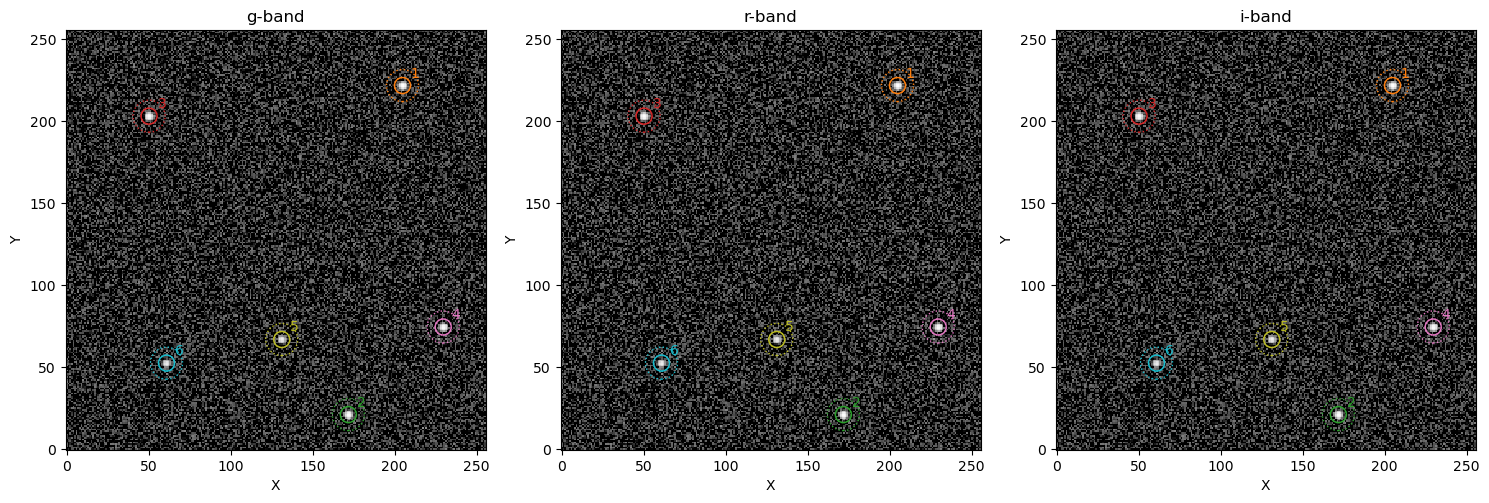

In [3]:
cat(overwrite=True)

We can see that six sources have been identified in each of the three sets of images. In this example, the source labelling is consistent across the catalogs because there are no field-of-view or pixel-scale differences between the simulated cameras. In practise, the source labelling will not usually be consistent across the catalogs, and so care must be taken when performing differential photometry that the same sources are being used for each filter (more on this later). After initialising our catalogs, a number of diagnostic plots are also generated. By default, these plots are not shown but are saved to the `out_directory/diag` directory. To display these plots in the console, users can set `show_diagnostic_plots=True` in `cat.initialise()`.

With our catalogs defined, we can now perform aperture photometry. To do this, we need to initialise either a `Photometer()` object for performing normal and optimal photometry, or a `ForcedPhotometer()` object for performing forced aperture and annulus photometry. In this example, we'll use both:

In [4]:
from opticam_new import ForcedPhotometer, Photometer

forced_phot = ForcedPhotometer(cat)
phot = Photometer(cat)

Both types of photometry take a `Catalog` object, and to perform photometry it is necessary to 'call' the photometry object, similarly to when we initialised our catalogs:

[OPTICAM] Performing forced photometry on g-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Saving g-band light curves: 100%|██████████| 6/6 [00:00<00:00, 1394.77it/s]


[OPTICAM] Performing forced photometry on r-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Saving r-band light curves: 100%|██████████| 6/6 [00:00<00:00, 1422.52it/s]


[OPTICAM] Performing forced photometry on i-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Saving i-band light curves: 100%|██████████| 6/6 [00:00<00:00, 1310.17it/s]


[OPTICAM] Performing photometry on g-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Saving g-band light curves: 100%|██████████| 6/6 [00:00<00:00, 2156.08it/s]


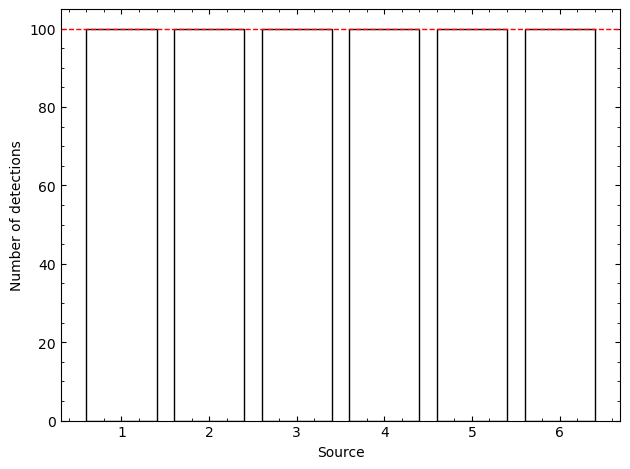

[OPTICAM] Performing photometry on r-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Saving r-band light curves: 100%|██████████| 6/6 [00:00<00:00, 2078.27it/s]


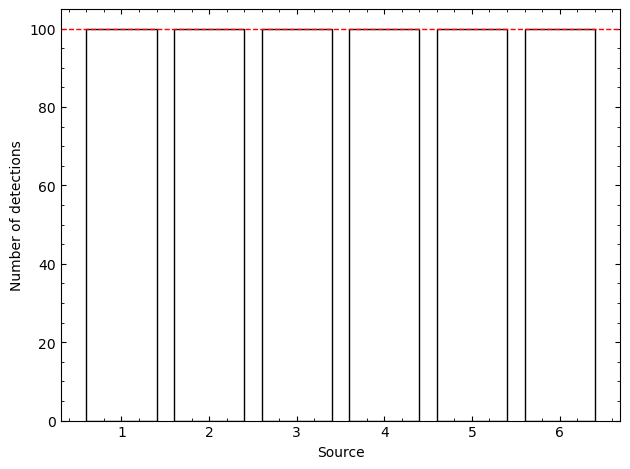

[OPTICAM] Performing photometry on i-band images:   0%|          | 0/100 [00:00<?, ?it/s]

[OPTICAM] Saving i-band light curves: 100%|██████████| 6/6 [00:00<00:00, 2233.59it/s]


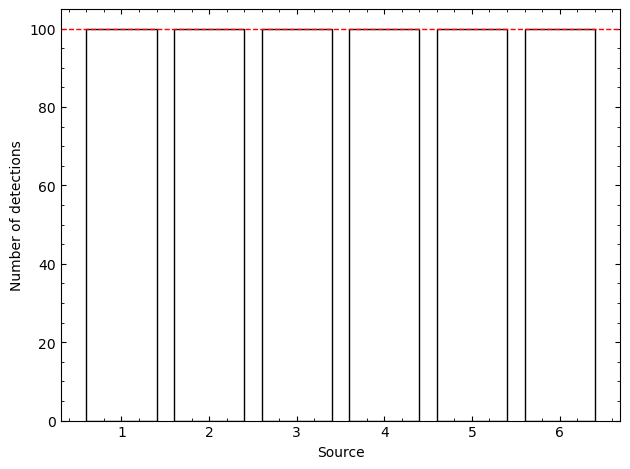

In [5]:
forced_phot(overwrite=True)
phot(overwrite=True)

`Photometry` requires fitting for the source positions in each image, making this routine generally more time consuming than `ForcedPhotometry` but the light curves often have better signal-to-noise ratios. When using `Photometry`, faint sources may be undetectable in some images, depending on the value of `threshold` specified in the `Catalog` object, meaning the number of data points in a resulting light curve may be less than the nominal number of exposures. In constrast, `ForcedPhotometry` light curves will always have the nominal number of data points, even if the signal-to-noise ratio is extremely low. The number of detections for each source can be seen in the plots produced by `Photometry` for each camera. As we can see above, all sources have the nomincal number of detections, shown by the dashed red line.

In this example, we will assume that source 2 is our target of interest, and will use all other sources for comparisons. In practise, the choice of comparison star(s) is cruical for obtaining a quality final light curve. Even for stars that are known to be constant emitters, it is important to consider things like where the source is on the CCD, since the systematics can vary with posiiton, as well as the source colour.

Let's now produce a relative light curve for source 2 using the 'annulus' light curves. First, however, we need to initialise a `DifferentialPhotometer` object. When initialising a `DifferentialPhotometer` object, we need to pass the directory path to the reduced data created by `Catalog`:

[OPTICAM] Filters: g-band, r-band, i-band


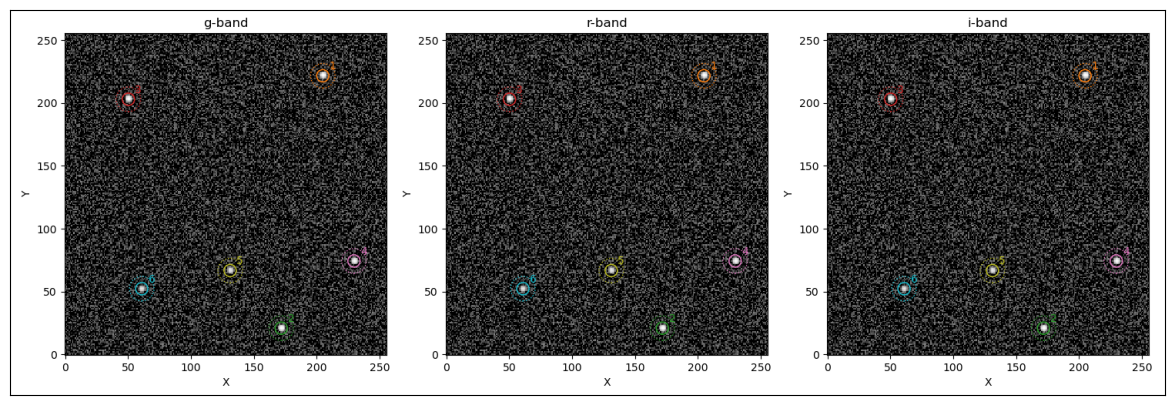

In [6]:
from opticam_new import DifferentialPhotometer

diff_phot = DifferentialPhotometer(
    out_directory='reduced',
    )

When initialising a `DifferentialPhotometer()` object, the source catalogs are output for convenience. We can now create our relative light curve:

r-band 2 [1, 3, 4, 5, 6]
i-band 2 [1, 3, 4, 5, 6]


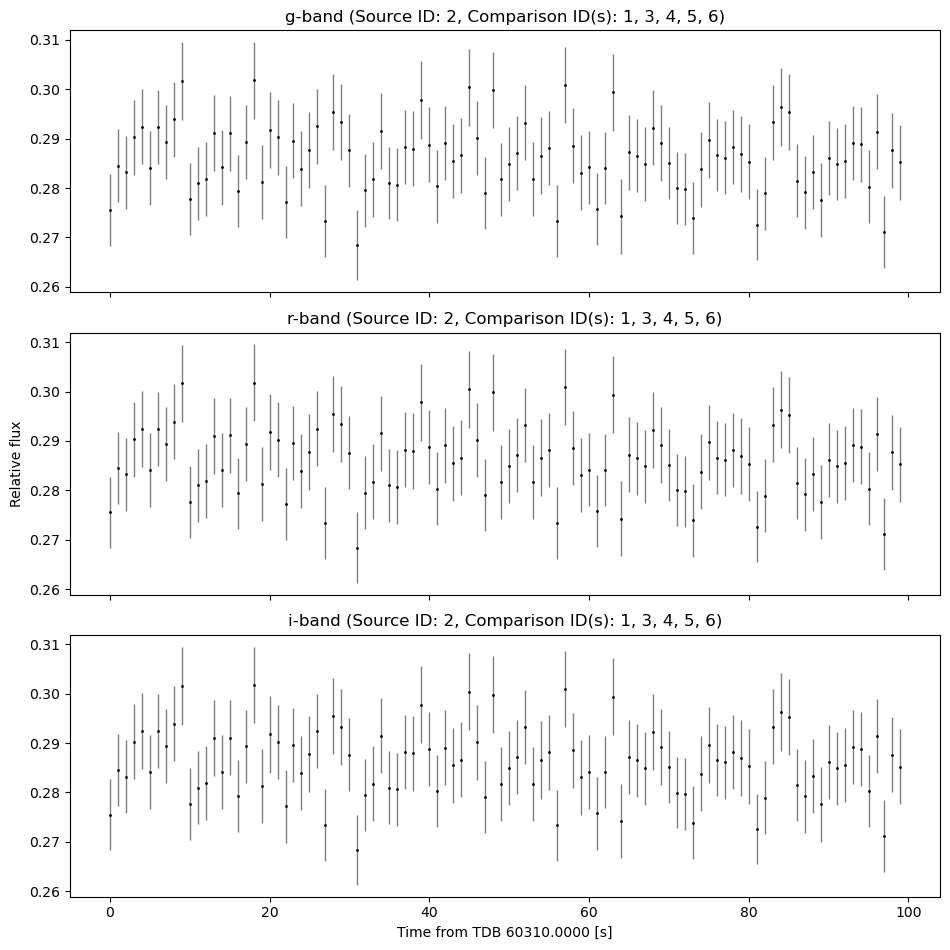

In [7]:
target = 2
comparisons = [1, 3, 4, 5, 6]

analyser = diff_phot.get_relative_light_curve('g-band', target, comparisons, phot_type='annulus', prefix='test',
                                              match_other_cameras=True, show_diagnostics=False)

To help identify suitable comparison sources, residual plots are created between the target and each comparison source's normalized light curves. These plots are saved in `out_directory/relative_light_curves/diag`, and will be displayed unless `show_diagnostics` is set to `False`. For this example, I have set `show_diagnostics=False` for simplicity, since I know all the comparison sources are good in this case (there are no position-dependent systematics or colour variations in the sources).

The `get_relative_light_curve()` method can also match sources across filters by setting `match_other_cameras=True`. However, this can misidentify sources, so care should be taken to check the correct sources are identified when `match_other_cameras=True`. In this case, we can see that the identified sources are correct, and so we don't have to manually create relative light curves for each filter.

When relative light curves are created, an `Analyser` object is returned. This analyser object can be used to perform a few basic timing analyses, such as computing periodograms and phase folding. In this case, we'll take a look at the periodograms for each camera and see if there's anything interesting there:

/home/zac/Documents/University/PhD/Repos/opticam_new/opticam_new/analyser.py:227: RuntimeWarning: divide by zero encountered in divide
  return 1 / x


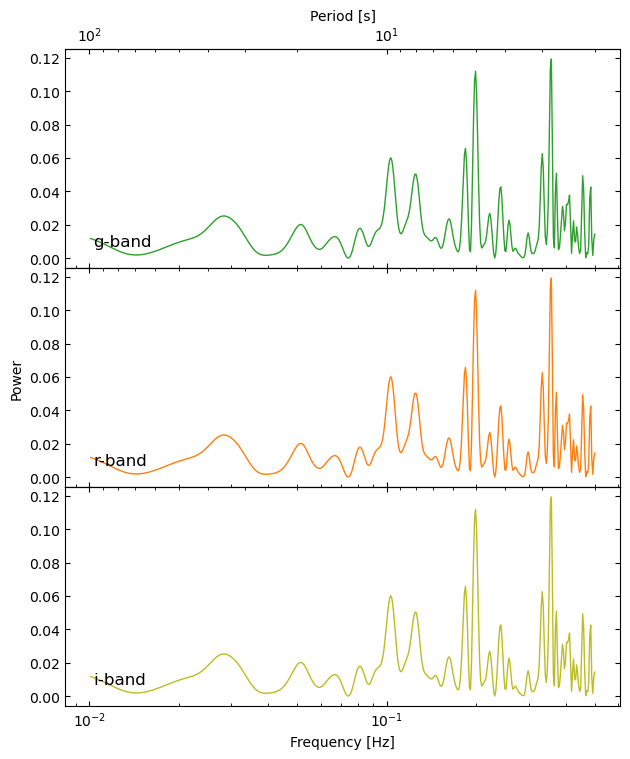

In [8]:
frequencies, periodograms = analyser.lomb_scargle(scale='log', show_plot=True)

As we can see, there are strong signals at 0.2 Hz and about 0.35 Hz. Let's see if we get a better signal-to-noise ratio using the 'optimal' photometry light curves:

r-band 2 [1, 3, 4, 5, 6]
i-band 2 [1, 3, 4, 5, 6]


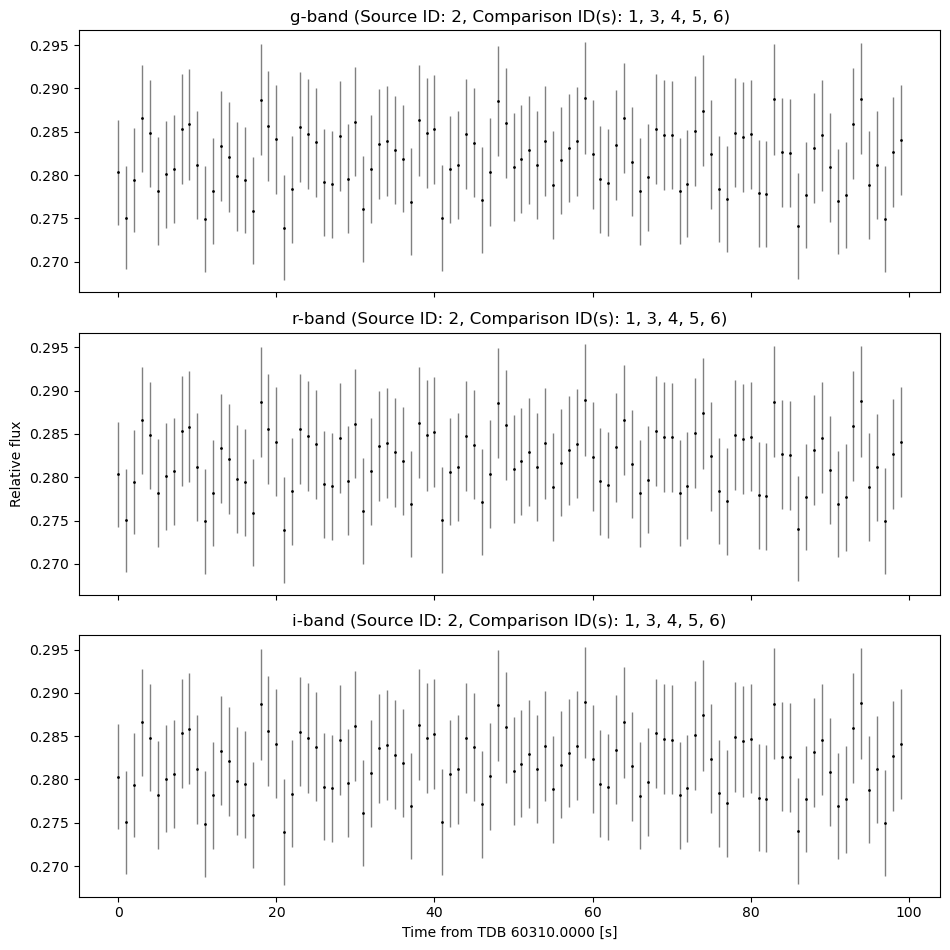

In [9]:
analyser = diff_phot.get_relative_light_curve('g-band', target, comparisons, phot_type='optimal', prefix="test",
                                              match_other_cameras=True, show_diagnostics=False)

/home/zac/Documents/University/PhD/Repos/opticam_new/opticam_new/analyser.py:227: RuntimeWarning: divide by zero encountered in divide
  return 1 / x


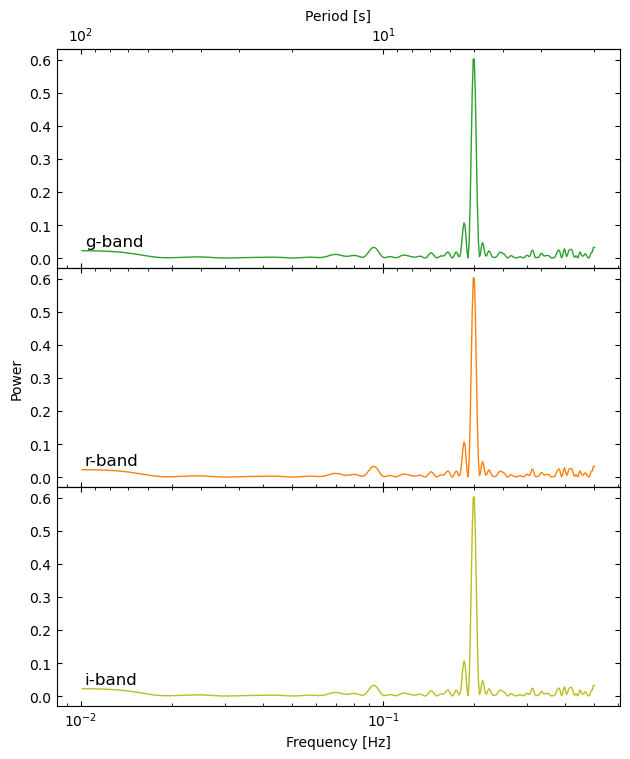

In [10]:
frequencies, powers = analyser.lomb_scargle(scale='log', show_plot=True)

Now the periodogram is dominated by the 0.2 Hz periodicity, demonstrating that the 0.35 Hz peak above was a result of noise (since these generated data are known to only contain a periodicity at 0.2 Hz).

In [11]:
import numpy as np
import astropy.units as u

f = frequencies[np.argmax(powers['g-band'])] * u.Hz

print(f)

0.19872022047640925 Hz


As we can see, the signal is much stronger. Let's also try phase folding to see the pulse shape:

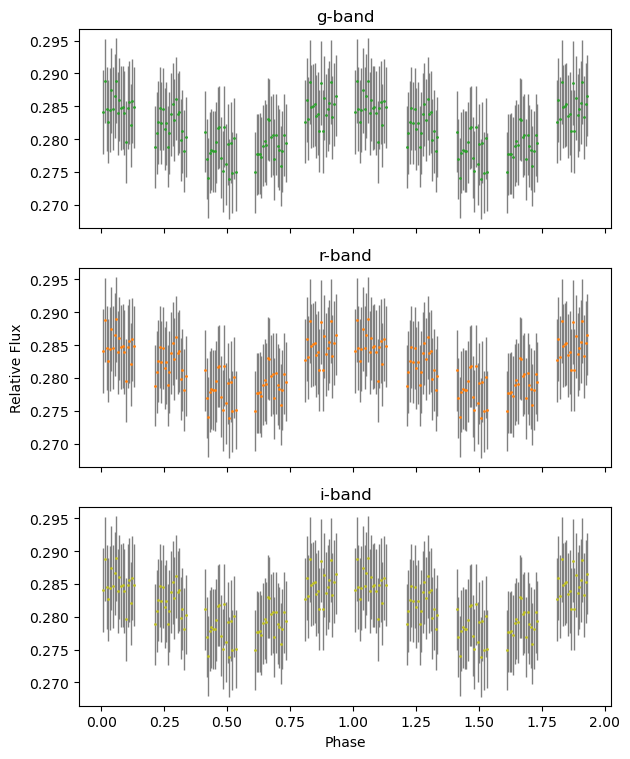

In [12]:
# NOTE: the period must be an astropy unit object (e.g. u.s, u.min, u.hour, u.day) to ensure the correct units are used
phases = analyser.phase_fold(period=1/f)

In [13]:
print(phases)

{'g-band': 0     0.334946
1     0.533666
2     0.732386
3     0.931106
4     0.129827
        ...   
95    0.213367
96    0.412087
97    0.610807
98    0.809527
99    0.008247
Name: TDB, Length: 100, dtype: float64, 'r-band': 0     0.334946
1     0.533666
2     0.732386
3     0.931106
4     0.129827
        ...   
95    0.213367
96    0.412087
97    0.610807
98    0.809527
99    0.008247
Name: TDB, Length: 100, dtype: float64, 'i-band': 0     0.334946
1     0.533666
2     0.732386
3     0.931106
4     0.129827
        ...   
95    0.213367
96    0.412087
97    0.610807
98    0.809527
99    0.008247
Name: TDB, Length: 100, dtype: float64}


The large error bars somewhat obscure the variations. Let's try phase binning instead:

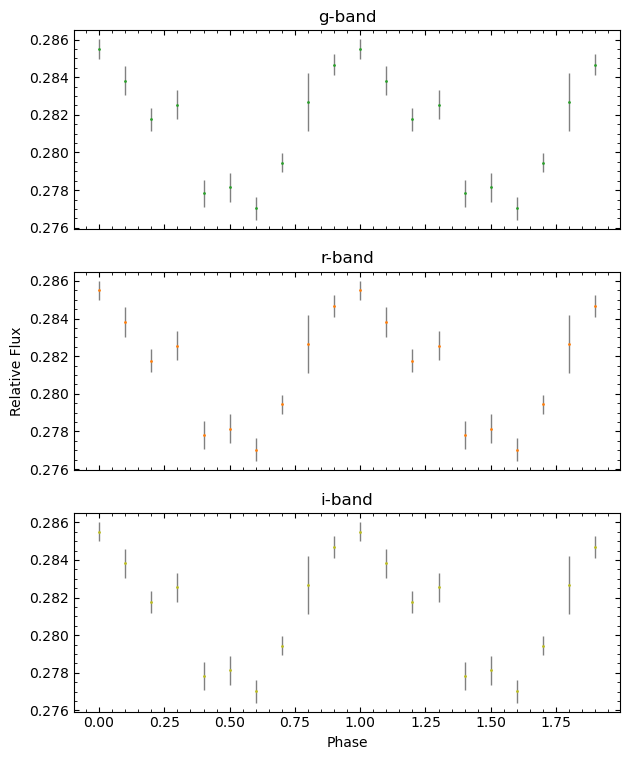

In [14]:
results = analyser.phase_bin(period=1/f)

In [15]:
print(results)

{'g-band': {'phase': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'flux': array([0.28549986, 0.28381929, 0.2817659 , 0.28254872, 0.2778206 ,
       0.27814409, 0.27702807, 0.27945227, 0.28267189, 0.28467294]), 'flux error': array([0.0005108 , 0.00078477, 0.00060506, 0.00076927, 0.00073359,
       0.00077286, 0.00060778, 0.00050774, 0.00154201, 0.00057924])}, 'r-band': {'phase': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'flux': array([0.28549986, 0.28381929, 0.2817659 , 0.28254872, 0.2778206 ,
       0.27814409, 0.27702807, 0.27945227, 0.28267189, 0.28467294]), 'flux error': array([0.0005108 , 0.00078477, 0.00060506, 0.00076927, 0.00073359,
       0.00077286, 0.00060778, 0.00050774, 0.00154201, 0.00057924])}, 'i-band': {'phase': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'flux': array([0.28549986, 0.28381929, 0.2817659 , 0.28254872, 0.2778206 ,
       0.27814409, 0.27702807, 0.27945227, 0.28267189, 0.28467294]), 'flux error': array([0.00051

The variations are much clearer now.

That concludes the basic usage tutorial for `opticam_new`! For more specific documentation on each stage of the pipeline, see the dedicated tutorials.